In [1]:
'''Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.
Data Provided by: https://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states'''

'Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.\nData Provided by: https://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states'

In [2]:
%matplotlib notebook
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats

In [3]:
# Load and display the data's information
df = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 65 columns):
id                    4870 non-null object
ad                    4870 non-null object
education             4870 non-null int8
ofjobs                4870 non-null int8
yearsexp              4870 non-null int8
honors                4870 non-null int8
volunteer             4870 non-null int8
military              4870 non-null int8
empholes              4870 non-null int8
occupspecific         4870 non-null int16
occupbroad            4870 non-null int8
workinschool          4870 non-null int8
email                 4870 non-null int8
computerskills        4870 non-null int8
specialskills         4870 non-null int8
firstname             4870 non-null object
sex                   4870 non-null object
race                  4870 non-null object
h                     4870 non-null float32
l                     4870 non-null float32
call                  4870 non-null float32
city        

In [4]:
# We can use the central limit theorem to find a normal distribution for applicants of both races
# To do so we can use bootstrapping with the mean function to get a normal distribution of means
# The null hypothesis will be that race is irrelevant to the success of the applicant in receiving callbacks
# The alternative hypothesis will be that being black will negatively affect your chances at receiving a callback
# and thus a job. I will set the significance level to be 2.5%.

# First split up the dataframe into two subsets based off of race
white_df = df[df.race=='w']
black_df = df[df.race=='b']

# First attempt to solve the question using statistics
null_hypothesis = 0;
white_call_std = np.std(white_df.call)
black_call_std = np.std(black_df.call)
white_call_mean = np.mean(white_df.call)
black_call_mean = np.mean(black_df.call)
diff_mean = white_call_mean - black_call_mean
diff_std = np.sqrt((white_call_std**2/len(white_df.call)) + (black_call_std**2/len(black_df.call)))
# This is the z-value for the significance level of ~1.25% on both sides of the distribution 
# (approximately 2.5% significance level)
Z_VAL_TWO_STD = 2.24
conf_val = Z_VAL_TWO_STD * diff_std
conf_interval = (-round(conf_val + diff_mean,4),+round(conf_val + diff_mean,4))
if((null_hypothesis >= conf_interval[0]) & (null_hypothesis <=conf_interval[1])):
   print(f"Since the null_hypothesis {round(null_hypothesis,2)} lies within the \
confidence interval {conf_interval}, we cannot reject the null hypothesis.")
else:
   print(f"Since the null_hypothesis {round(null_hypothesis,2)} is outside of the \
confidence interval {conf_interval}, we reject the null hypothesis and find that \
the job opportunities are not equivalent for both races.")

print(f"\nWe can state with 97.5% confidence that the difference between the callback rate for white and black applicants is\
 {round(diff_mean,4)} +/- {round(conf_val,3)}.")

Since the null_hypothesis 0 lies within the confidence interval (-0.0495, 0.0495), we cannot reject the null hypothesis.

We can state with 97.5% confidence that the difference between the callback rate for white and black applicants is 0.032 +/- 0.017.


<IPython.core.display.Javascript object>


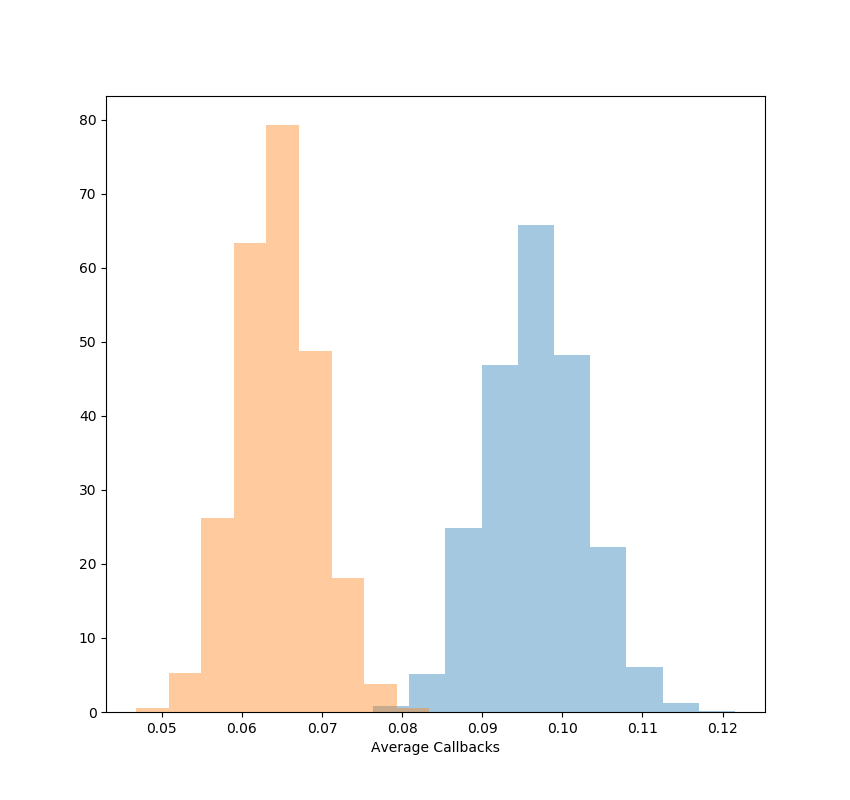

In [5]:
# Create a bootstrap sample for each race and plot them

def draw_bs_reps(data, func, size=1):
    '''Use a one dimensional set of data to create an array of bootstrap replicates'''
    bs_replicates = np.empty(size)
    
    # Generate replicates by reorganizing the data then randomly selecting and replacing the data before running
    # the function on the data to create an array of bootstrap replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates

white_callback_bs = draw_bs_reps(white_df.call, np.mean, 10000)    
black_callback_bs = draw_bs_reps(black_df.call, np.mean, 10000)   
_ = plt.figure(figsize=(8.5,8))
_ = plt.subplot(1,1,1)
# Lets first take a look to see an approximation of both race populations
plt.hist(white_callback_bs,density=True,alpha=.4)
plt.hist(black_callback_bs,density=True,alpha=.4)
plt.xlabel("Average Callbacks")
plt.show()

<IPython.core.display.Javascript object>


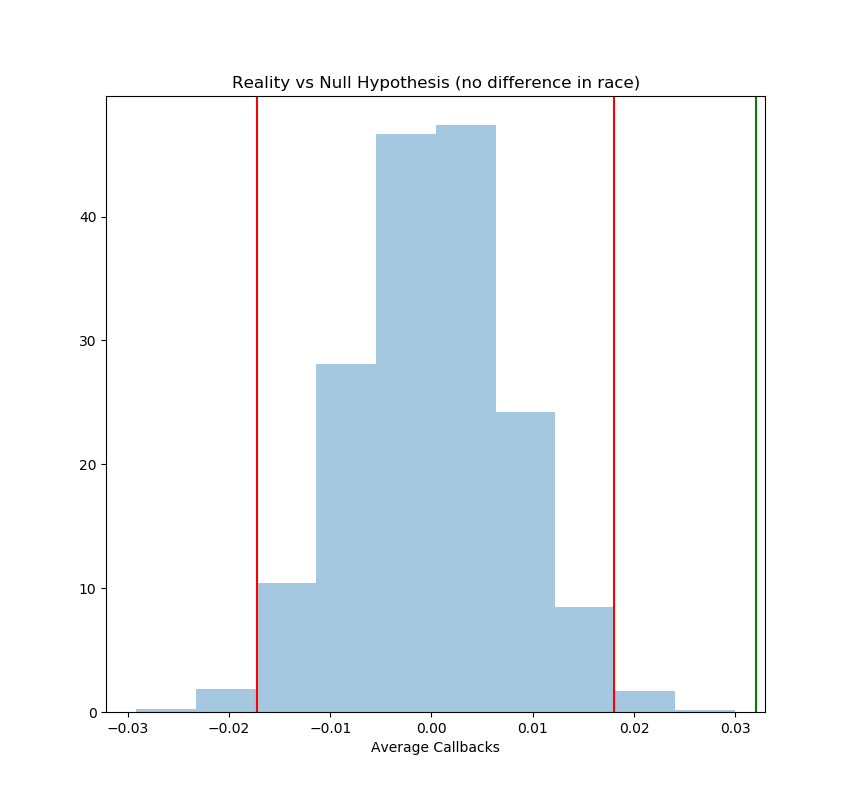

In [14]:
# Create two bootstrap replicates from shifted arrays 
mean_call = np.mean(df.call)

# Generate shifted arrays
white_call_shifted = white_df.call - np.mean(white_df.call) + mean_call
black_call_shifted = black_df.call - np.mean(black_df.call) + mean_call 

# Compute 10,000 bootstrap replicates from shifted arrays
shifted_white_bs = draw_bs_reps(white_call_shifted, np.mean, 10000)
shifted_black_bs = draw_bs_reps(black_call_shifted, np.mean, 10000)

# Get replicates of difference of means
shifted_bs = shifted_white_bs - shifted_black_bs

p_val = np.sum(shifted_bs >= diff_mean) / len(shifted_bs)

perm_callback_bs = draw_bs_reps(df.call,np.mean,10000)
_ = plt.figure(figsize=(8.5,8))
_ = plt.subplot(1,1,1)

# Lets first take a look 
plt.hist(shifted_bs,density=True,alpha=.4)
plt.xlabel("Average Callbacks")
conf_interval = np.percentile(shifted_bs,[1.25,98.75])
plt.axvline(x=conf_interval[0],color='r')
plt.axvline(x=conf_interval[1],color='r')
plt.axvline(x=diff_mean,color='g')
plt.title("Reality vs Null Hypothesis (no difference in race)")
plt.show()

print("The p-value {p_val} is less than our significance level (0.025) thus we can reject the null hypothesis. \
From the figure, you can easily see how reality (shown by the green line) is not contained in our confidence interval \
(shown in red lines), this means that the difference ")

# Conclusion
### This examination of the data does show strong statistical correlation that race/name has an effect on your success in job searches but it does not prove that this is the only or most important factor for getting a callback.

<IPython.core.display.Javascript object>


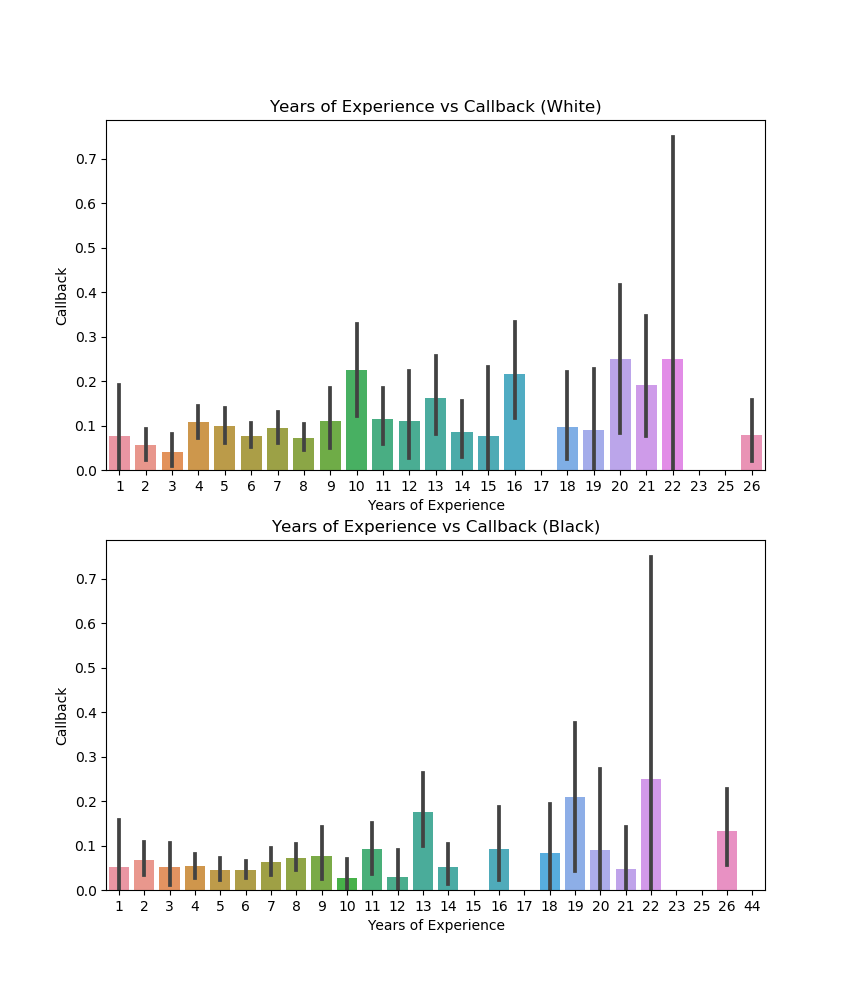

In [7]:
# Lets take a look at a few other factors that may or may not influence callback
_ = plt.figure(figsize=(8.5,10))
_ = plt.subplot(2,1,1)
sns.barplot("yearsexp","call",data=white_df)
plt.title("Years of Experience vs Callback (White)")
plt.xlabel("Years of Experience")
plt.ylabel("Callback")
_ = plt.subplot(2,1,2)
sns.barplot("yearsexp","call",data=black_df)
plt.title("Years of Experience vs Callback (Black)")
plt.xlabel("Years of Experience")
plt.ylabel("Callback")
plt.show()
# We can see some growth for the callback percentage as the applicant is more experienced across both races
# Though we can also see that there is a visible difference in callback percentage for white applicants 
# early on in their career

<IPython.core.display.Javascript object>


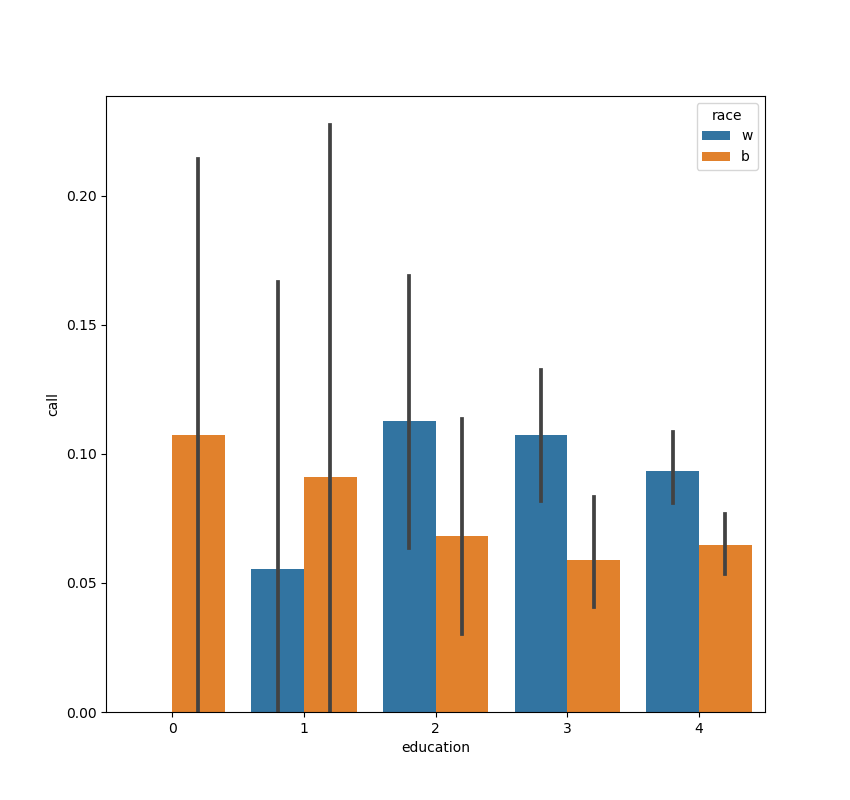

In [8]:
_ = plt.figure(figsize=(8.5,8))
_ = plt.subplot(1,1,1)
sns.barplot("education","call",data=df,hue='race')
plt.show()
# Oddly enough there is no data for white applicants with no years of education

<IPython.core.display.Javascript object>


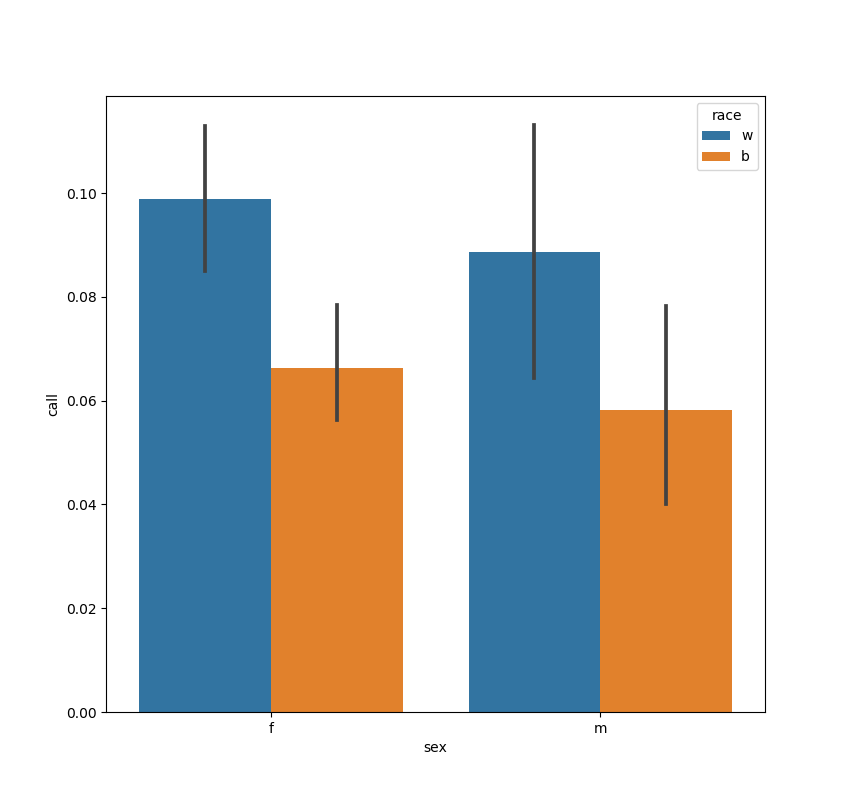

In [9]:
_ = plt.figure(figsize=(8.5,8))
_ = plt.subplot(1,1,1)
sns.barplot("sex","call",data=df,hue='race')
plt.show()
# Another odd thing about this data is that the male to female callback percentages are not equal.
# According to this data, females are more likely to receive a callback vs males across both races.

<IPython.core.display.Javascript object>


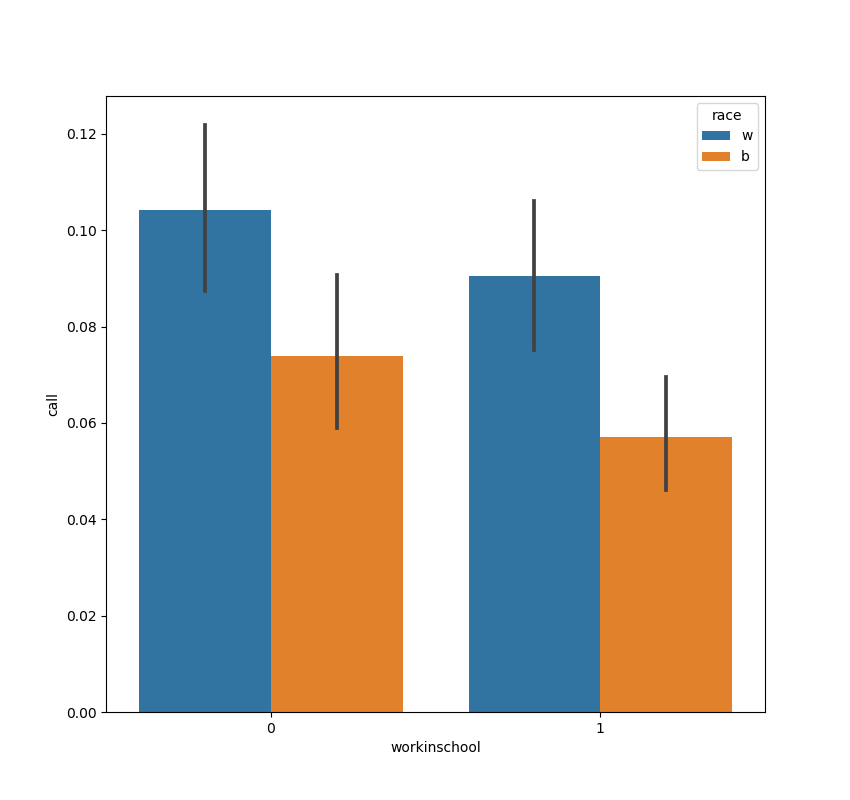

In [10]:
_ = plt.figure(figsize=(8.5,8))
_ = plt.subplot(1,1,1)
sns.barplot("workinschool","call",data=df,hue='race')
plt.show()